In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Load the training data into feature matrix, class labels, and event ids:

In [2]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../data/train.csv'
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

### Simple data description 
- all variables are floating point, except PRI_jet_num which is integer
- variables prefixed with PRI (for PRImitives) are “raw” quantities about the bunch collision as measured by the detector.
- variables prefixed with DER (for DERived) are quantities computed from the primitive features, which were selected by the physicists of ATLAS.
- it can happen that for some entries some variables are meaningless or cannot be computed; in this case, their value is −999.0, which is outside the normal range of all variables.

In [3]:
print('y shape = ' + str(y.shape) + '\ntX shape =' + str(tX.shape) + '\nids shape = ' + str(ids.shape))

y shape = (250000,)
tX shape =(250000, 30)
ids shape = (250000,)


Description of the data:
- `y` (N) is composed of the labels (-1 or 1) of all the samples.  
- `tX` (N x F) is composed of the values of the features (F) for all samples (N)  
- `ids` (N) is composed of all the index (100000-349999) of the samples (N)  
  
Moreover, the number of features is 30 (F=30) and the number of samples is 250'000 (N=250'000). Non recorded data has value `-999`. 

In [4]:
from implementations import *

# Exploratory analysis

In [ ]:
tX0 = np.where(tX==-999, np.nan,tX)

for f in [2, 6, 10, 15, 20, 27]:
    plot_feature(ids, tX0, y, f)

# Data pre-processing 

So for the data pre-processing, the first step is to remove the visible outliers in the Exploratory Analysis plots. 

In [5]:
# remove outliers based on the plots in the Exploratory analysis
y, tX = remove_outliers(y, tX, [0, 2, 3, 8, 13, 16, 19, 21, 23, 26],
                       [1100, 1000, 1000, 2500, 500, 500, 800, 1800, 800, 600])

# Feature processing

Then with this data, we separate the data points based on the categorical data: jet. We keep three matrices with `jet = 0`, `jet = 1` and `jet > 2`. We will futher train separately our models on each of these sub-matrices and have separated, learning rates, penalities or polynomial degrees for each. 

We still keep the whole data matrix to do the same treatments and generate whole weight matrices as a comparison. 

In [7]:
indices = np.random.choice(tX.shape[0], 1500, replace=False)

In [8]:
y = y[indices,]
tX = tX[indices,:]

In [9]:
idx0, y_jet0, tX_jet0, idx1, y_jet1, tX_jet1, idx2, y_jet2, tX_jet2 = separate_jet(y, tX)

For each dataset, we clean them by setting all missing values `-999` to `NaN`, then when for a feature the ratio of missing values reaches a threshold, we remove the whole feature from the dataset. The remaining missing data are replaced by the median value in the column (we also tried to replace the missing data by the mean value of the feature or a gaussian distribution. Then we standarize the data. 

In [10]:
missingness_cutoff = 0.95

In [11]:
tX, rmX = missingness_filter(tX, missingness_cutoff)
rmX = np.append(rmX, 22)

In [12]:
tX, mtX = impute_median_train(tX)

In [13]:
tX_jet0, rmX_jet0 = missingness_filter(tX_jet0, missingness_cutoff)
tX_jet1, rmX_jet1 = missingness_filter(tX_jet1, missingness_cutoff)
tX_jet2, rmX_jet2 = missingness_filter(tX_jet2, missingness_cutoff)
tX_jet0, median_jet0 = impute_median_train(tX_jet0)
tX_jet1, median_jet1 = impute_median_train(tX_jet1)
tX_jet2, median_jet2 = impute_median_train(tX_jet2)

In [14]:
print("tX shape={tXs}\ntX_jet0 shape={tX0s}\ntX_jet1 shape={tX1s}\ntX_jet2+ shape={tX2s}".format(
    tXs=tX.shape, tX0s=tX_jet0.shape, tX1s=tX_jet1.shape, tX2s=tX_jet2.shape))

print("\nremoved columns for :\ntX={rmX}\ntX_jet0={rmX0}\ntX_jet1={rmX1}\ntX_jet2+={rmX2}".format(
    rmX=rmX, rmX0=rmX_jet0, rmX1=rmX_jet1, rmX2=rmX_jet2))

tX shape=(1500, 30)
tX_jet0 shape=(577, 19)
tX_jet1 shape=(503, 22)
tX_jet2+ shape=(420, 29)

removed columns for :
tX=[22]
tX_jet0=[ 4  5  6 12 22 23 24 25 26 27]
tX_jet1=[ 4  5  6 12 25 26 27]
tX_jet2+=[]


## Least squares

### Full dataset

In [ ]:
tX1,_,_ = standardize_train(tX.copy())

In [ ]:
(w_ls, loss_ls) = least_squares(y, tX1)

print("w* ={w}\n\nmse={loss}".format(w=w_ls, loss=loss_ls))

### Jet sub-datasets

In [ ]:
for index_jet, (yi, txi) in enumerate(zip([y_jet0, y_jet1, y_jet2], [tX_jet0, tX_jet1, tX_jet2])):
    tx1, _, _ = standardize_train(txi.copy())
    (w_ls, loss_ls) = least_squares(yi, tx1)
    print("w_jet{jet}* = {w}\nmse = {loss}\n\n".format(
    jet=index_jet, w=w_ls, loss=loss_ls))

## Least squares with Gradient Descent

### Full dataset

In [ ]:
#define parameters
initial_w = np.zeros(tX.shape[1])
max_iters = 100
gammas = np.logspace(-6, 0, 20)

losses_gd = np.empty(len(gammas))
ws_gd = np.empty((len(gammas), len(initial_w)))

tX1,_,_ = standardize_train(tX)

for idx, gamma in enumerate(gammas):
    (w, loss) = least_squares_GD(y, tX1, initial_w, max_iters, gamma)
    losses_gd[idx] = loss
    ws_gd[idx, :]=w

In [ ]:
#plot the losses per gamma
fig, ax = plt.subplots()
ax.semilogx(gammas, losses_gd)

ax.set(xlabel='gamma', ylabel='MSE',
       title='Mean square error per choice of learning rate')
ax.grid()
ax.set_ylim([0, 0.8])
plt.show()

In [ ]:
idx = np.nanargmin(losses_gd)

w_gd = ws_gd[idx]
gamma_gd = gammas[idx]

print("w* ={w}\n\nmse={loss}\n\ngamma={gamma}".format(
    w=w_gd, loss=losses_gd[idx], gamma=gamma_gd))

### Jet sub-datasets

In [ ]:
#define parameters
max_iters = 100
gammas = np.logspace(-6, 0, 10)

for index_jet, (yi, txi) in enumerate(zip([y_jet0, y_jet1, y_jet2], [tX_jet0.copy(), tX_jet1.copy(), tX_jet2.copy()])):
    tx1, _, _ = standardize_train(txi.copy())
    initial_w = np.zeros(tx1.shape[1])
    losses_gd = np.empty(len(gammas))
    ws_gd = np.empty((len(gammas), len(initial_w)))

    for index_g, gamma in enumerate(gammas):
        (w, loss) = least_squares_GD(yi, tx1, initial_w, max_iters, gamma)
        losses_gd[index_g] = loss
        ws_gd[index_g, :]=w
        
    idx = np.nanargmin(losses_gd)
    w_gd = ws_gd[idx]
    gamma_gd = gammas[idx]
    print("w_jet{jet}* = {w}\nmse = {loss}\ngamma = {gamma}".format(
    jet=index_jet, w=w_gd, loss=losses_gd[idx], gamma=gamma_gd))

## Least squares with Stochastic Gradient Descent

### Full dataset

In [ ]:
initial_w = np.zeros(tX.shape[1])
max_iters = 100
gammas = np.logspace(-6, 0, 20)

losses_sgd = np.empty(len(gammas))
ws_sgd = np.empty((len(gammas), len(initial_w)))

tX1, _, _ = standardize_train(tX.copy())

for idx, gamma in enumerate(gammas):
    (w, loss) = least_squares_SGD(y, tX1, initial_w, max_iters, gamma)
    losses_sgd[idx] = loss
    ws_sgd[idx,:] = w

In [ ]:
#plot the losses per gamma used
fig, ax = plt.subplots()
ax.semilogx(gammas, losses_sgd)

ax.set(xlabel='gamma', ylabel='MSE',
       title='Mean square error per choice of learning rate')
ax.grid()
ax.set_ylim([0, 1])
plt.show()

In [ ]:
idx = np.nanargmin(losses_sgd)

w_sgd = ws_sgd[idx]
gamma_sgd = gammas[idx]

print("w*={w}\n\nmse={loss}\n\ngamma={gamma}".format(
    w=w_sgd, loss=losses_sgd[idx], gamma=gamma_sgd ))

### Jet sub-datasets

In [ ]:
#define parameters
max_iters = 100
gammas = np.logspace(-6, 0, 10)

for index_jet, (yi, txi) in enumerate(zip([y_jet0, y_jet1, y_jet2], [tX_jet0, tX_jet1, tX_jet2])):
    tx1, _, _ = standardize_train(txi.copy())
    initial_w = np.zeros(tx1.shape[1])
    losses_gd = np.empty(len(gammas))
    ws_gd = np.empty((len(gammas), len(initial_w)))

    for index_g, gamma in enumerate(gammas):
        (w, loss) = least_squares_SGD(yi, tx1, initial_w, max_iters, gamma)
        losses_gd[index_g] = loss
        ws_gd[index_g, :]=w
        
    idx = np.nanargmin(losses_gd)
    w_gd = ws_gd[idx]
    gamma_gd = gammas[idx]
    print("w_jet{jet}* = {w}\nmse = {loss}\ngamma = {gamma}".format(
    jet=index_jet, w=w_gd, loss=losses_gd[idx], gamma=gamma_gd))

## Ridge regression

For ridge regression, we have two parameters to optimize, the lambda (penality) and degree (complexity). To do so, we use a cross validation that optimizes both at the same time. 

Then a biais and variance decomposition is used to visualize if the methods tend to underfit or overfit. 

### Full dataset

#### Cross-validation hyperparameter selection

In [28]:
w_interaction = True

In [29]:
seed = 1
degree_ri = 1
k_fold = 4
lambdas = np.logspace(-20, -8, 13)
degrees = range(1, 15)

k_indices = build_k_indices(y, k_fold, seed)

rmse_tr_ri, rmse_te_ri, acc_measures = cross_validation_wAcc(y, tX, k_indices, k_fold, degrees, 
                                          lambdas , ml_function = 'ri', max_iters = 100, 
                                          gamma = 0.05, verbose = True, interaction=w_interaction)

Added 435 interaction features
Finished preparing data for cross-validation 

Completed degree 14/14
 Completed lambda 1/13
Completed degree 14/14
 Completed lambda 2/13
Completed degree 14/14
 Completed lambda 3/13
Completed degree 14/14
 Completed lambda 4/13
Completed degree 14/14
 Completed lambda 5/13
Completed degree 14/14
 Completed lambda 6/13
Completed degree 14/14
 Completed lambda 7/13
Completed degree 14/14
 Completed lambda 8/13
Completed degree 14/14
 Completed lambda 9/13
Completed degree 14/14
 Completed lambda 10/13
Completed degree 14/14
 Completed lambda 11/13
Completed degree 14/14
 Completed lambda 12/13
Completed degree 14/14
 Completed lambda 13/13


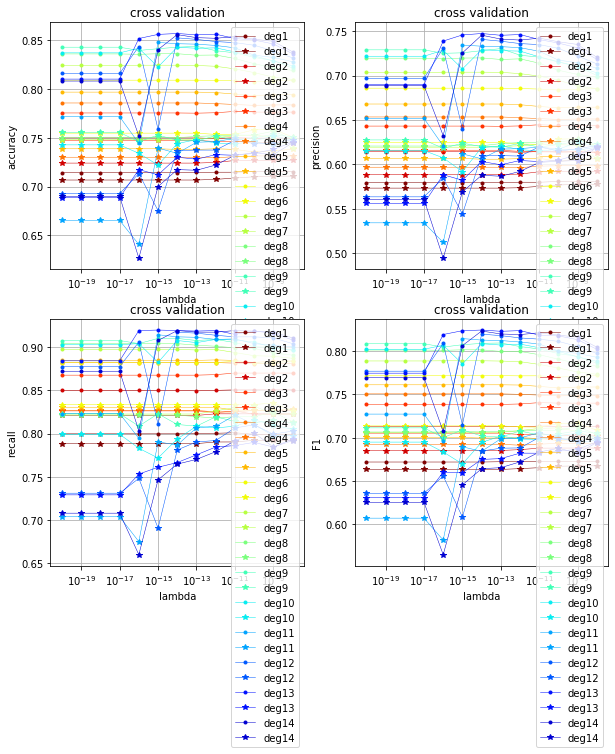

In [17]:
vis_cv_acc(degrees,lambdas,acc_measures)

In [30]:
idx = np.unravel_index(np.nanargmax(acc_measures["acc_te"]), acc_measures["acc_te"].shape)
lambda_ri = lambdas[idx[0]]
degree_ri = degrees[idx[1]]

print("lambda*={lambda_}\n\ndegree*={degree}\n\nrmse train={rmse_tr}\n\nrmse test={rmse_te}\n\nacc train={acc_tr}\n\nacc test={acc_te}".format(
    lambda_=lambda_ri, degree=degree_ri, rmse_tr=rmse_tr_ri[idx], rmse_te=rmse_te_ri[idx],acc_tr=acc_measures["acc_tr"][idx], acc_te=acc_measures["acc_te"][idx]))

lambda*=1e-12

degree*=3

rmse train=0.19006533631983685

rmse test=4.480798016246147

acc train=0.8968888888888888

acc test=0.6839999999999999


In [31]:
w_ri, loss_ri, acc_measures_ri, data_meas_ri = build_final_model(y, tX, degree_ri,
                                                      lambda_ri, ml_function = 'ri', interaction = w_interaction)

In [32]:
data_meas_ri["mean"].shape

(526,)

In [33]:
print(acc_measures_ri)

{'acc': 0.86, 'pre': 0.75642965204236, 'rec': 0.9107468123861566, 'f1': 0.8264462809917356}


#### Bias-variance decomposition for complexity determination

In [ ]:
ratio_train = 0.1
seeds = range(50)

In [ ]:
rmse_tr_bv = np.empty((len(seeds), len(degrees)))
rmse_te_bv = np.empty((len(seeds), len(degrees)))

for index_seed, seed in enumerate(seeds):
    np.random.seed(seed)
    x_tr, x_te, y_tr, y_te = split_data(tX.copy(), y, ratio_train, seed) 
    
    x_tr, x_te = standardize_both(x_tr, x_te)
    
    for index_deg, deg in enumerate(degrees): 
        tx_tr = build_poly(x_tr, deg)
        tx_te = build_poly(x_te, deg)
            
        w_tr, mse_tr = ridge_regression(y_tr, tx_tr, lambda_ri)
        mse_te = compute_mse(y_te, tx_te, w_tr)
            
        rmse_tr_bv[index_seed][index_deg] = np.sqrt(2*mse_tr)
        rmse_te_bv[index_seed][index_deg] = np.sqrt(2*mse_te)

In [ ]:
bias_variance_decomposition_visualization(degrees, rmse_tr_bv, rmse_te_bv)

Based on the plot above, change the value of `degree_ri` manually. 

### Jet sub-datasets

#### Cross-validation for hyperparameter selection

In [ ]:
seed = 1
degree_ri = 1
k_fold = 4
lambdas = np.logspace(-20, -8, 13)
degrees = range(1, 15)

k_indices = build_k_indices(y_jet0, k_fold, seed)

rmse_tr_ri, rmse_te_ri, acc_measures = cross_validation_wAcc(y_jet0, tX_jet0, k_indices, k_fold, degrees, 
                                          lambdas , ml_function = 'ri', max_iters = 100, 
                                          gamma = 0.05, verbose = True, interaction=w_interaction)

idx = np.unravel_index(np.nanargmax(acc_measures["acc_te"]), acc_measures["acc_te"].shape)
lambda_ri_jet0 = lambdas[idx[0]]
degree_ri_jet0 = degrees[idx[1]]

print("lambda*={lambda_}\n\ndegree*={degree}\n\nrmse train={rmse_tr}\n\nrmse test={rmse_te}\n\nacc train={acc_tr}\n\nacc test={acc_te}".format(
    lambda_=lambda_ri_jet0, degree=degree_ri_jet0, rmse_tr=rmse_tr_ri[idx], rmse_te=rmse_te_ri[idx],acc_tr=acc_measures["acc_tr"][idx], acc_te=acc_measures["acc_te"][idx]))

vis_cv_acc(degrees,lambdas,acc_measures)

w0_ri, loss0_ri, acc_measures0_ri, data_meas0_ri = build_final_model(y_jet0, tX_jet0, degree_ri_jet0,
                                                      lambda_ri_jet0, ml_function = 'ri', interaction = w_interaction)

print(acc_measures0_ri)

In [ ]:
k_indices = build_k_indices(y_jet1, k_fold, seed)

rmse_tr_ri, rmse_te_ri, acc_measures = cross_validation_wAcc(y_jet1, tX_jet1, k_indices, k_fold, degrees, 
                                          lambdas , ml_function = 'ri', max_iters = 100, 
                                          gamma = 0.05, verbose = True, interaction=w_interaction)

idx = np.unravel_index(np.nanargmax(acc_measures["acc_te"]), acc_measures["acc_te"].shape)
lambda_ri_jet1 = lambdas[idx[0]]
degree_ri_jet1 = degrees[idx[1]]

print("lambda*={lambda_}\n\ndegree*={degree}\n\nrmse train={rmse_tr}\n\nrmse test={rmse_te}\n\nacc train={acc_tr}\n\nacc test={acc_te}".format(
    lambda_=lambda_ri_jet1, degree=degree_ri_jet1, rmse_tr=rmse_tr_ri[idx], rmse_te=rmse_te_ri[idx],acc_tr=acc_measures["acc_tr"][idx], acc_te=acc_measures["acc_te"][idx]))

vis_cv_acc(degrees,lambdas,acc_measures)

w1_ri, loss1_ri, acc_measures1_ri, data_meas1_ri = build_final_model(y_jet1, tX_jet1, degree_ri_jet1,
                                                      lambda_ri_jet1, ml_function = 'ri', interaction = w_interaction)

print(acc_measures1_ri)

In [ ]:
k_indices = build_k_indices(y_jet2, k_fold, seed)

rmse_tr_ri, rmse_te_ri, acc_measures = cross_validation_wAcc(y_jet2, tX_jet2, k_indices, k_fold, degrees, 
                                          lambdas , ml_function = 'ri', max_iters = 100, 
                                          gamma = 0.05, verbose = True, interaction=w_interaction)

idx = np.unravel_index(np.nanargmax(acc_measures["acc_te"]), acc_measures["acc_te"].shape)
lambda_ri_jet2 = lambdas[idx[0]]
degree_ri_jet2 = degrees[idx[1]]

print("lambda*={lambda_}\n\ndegree*={degree}\n\nrmse train={rmse_tr}\n\nrmse test={rmse_te}\n\nacc train={acc_tr}\n\nacc test={acc_te}".format(
    lambda_=lambda_ri_jet2, degree=degree_ri_jet2, rmse_tr=rmse_tr_ri[idx], rmse_te=rmse_te_ri[idx],acc_tr=acc_measures["acc_tr"][idx], acc_te=acc_measures["acc_te"][idx]))

vis_cv_acc(degrees,lambdas,acc_measures)

w2_ri, loss2_ri, acc_measures2_ri, data_meas2_ri = build_final_model(y_jet2, tX_jet2, degree_ri_jet2,
                                                      lambda_ri_jet2, ml_function = 'ri', interaction = w_interaction)

print(acc_measures2_ri)

## Logistic regression

### Full dataset

In [ ]:
ltX = build_poly_inter(tX.copy(), 1, interaction = w_interaction)
ltX, _, _ = standardize_train(ltX)

In [ ]:
yl = np.where(y==-1, 0, y)
max_iters = 1000
gammas = np.logspace(-10, -1, 20)
initial_w = np.zeros(ltX.shape[1])

In [ ]:
losses_lr = np.empty(len(gammas))
ws_lr = np.empty((len(gammas), len(initial_w)))
for idx, gamma in enumerate(gammas):
    (w, loss) = logistic_regression(yl, ltX, initial_w, max_iters, gamma)
    losses_lr[idx] = loss
    ws_lr[idx, :] = w

In [ ]:
#plot the losses per gamma used
fig, ax = plt.subplots()
ax.semilogx(gammas, losses_lr)

ax.set(xlabel='gamma', ylabel='loglikelihood',
       title='Log likelihood per choice of learning rate')
ax.grid()
plt.show()

In [ ]:
idx = np.nanargmin(losses_lr)

w_lr = ws_lr[idx]
gamma_lr = gammas[idx]

print("w* ={w}\n\nloglikelihood loss={loss}\n\ngamma={gamma}".format(
    w=w_lr, loss=losses_lr[idx], gamma = gamma_lr))

#### Cross-validation for hyperparameter determination

In [ ]:
seed = 1
k_fold = 4
degrees = range(1, 9)

k_indices = build_k_indices(y, k_fold, seed)

loss_tr_lr, loss_te_lr, acc_measures_lr = cross_validation_wAcc(yl, tX, k_indices, k_fold, degrees, lambdas = [0],
                                                                 ml_function = 'lr', max_iters = 1000, gamma = gamma_lr,
                                                                 verbose = True, interaction = w_interaction)

In [ ]:
vis_cv_acc(degrees,lambdas,acc_measures_lr)

In [ ]:
loss_te_lr = np.array(loss_te_lr)
loss_tr_lr = np.array(loss_tr_lr)

idx = np.nanargmax(acc_measures_lr["acc_te"])

degree_lr = degrees[idx]

print("degree*={degree}\n\nloglikelihood train={loss_tr}\n\nloglikelihood test={loss_te}\n\nacc train={acc_tr}\n\nacc test={acc_te}".format(
    degree=degree_lr, loss_tr=loss_tr_lr.flatten()[idx], loss_te=loss_te_lr.flatten()[idx],
    acc_tr=acc_measures_lr["acc_tr"].flatten()[idx], acc_te=acc_measures_lr["acc_te"].flatten()[idx]))

## Regularized logistic regression

### Full dataset

In [ ]:
ltX = build_poly_inter(tX.copy(), 1, interaction = w_interaction)
ltX, _, _ = standardize_train(ltX)

In [ ]:
initial_w = np.zeros(ltX.shape[1])
max_iters = 1000
gammas = np.logspace(-10, -1, 20)
lambda_rlr = lambda_ri

In [ ]:
losses_rlr = np.empty(len(gammas))
ws_rlr = np.empty((len(gammas), len(initial_w)))
for idx, gamma in enumerate(gammas):
    (w, loss) = reg_logistic_regression(yl, ltX, lambda_rlr, initial_w, max_iters, gamma)
    losses_rlr[idx] = loss
    ws_rlr[idx, :] = w

In [ ]:
#plot the losses per gamma used
fig, ax = plt.subplots()
ax.semilogx(gammas, losses_rlr)

ax.set(xlabel='gamma', ylabel='loglikelihood',
       title='Log likelihood per choice of learning rate')
ax.grid()
plt.show()

In [ ]:
idx = np.nanargmin(losses_rlr)

w_rlr = ws_rlr[idx]
gamma_rlr = gammas[idx]

print("w* ={w}\n\nloglikelihood loss={loss}\n\ngamma={gamma}".format(
    w=w_rlr, loss=losses_rlr[idx], gamma = gamma_rlr))

#### Cross-validation hyperparameter selection

In [ ]:
seed = 1
degree_rlr = 1
k_fold = 4
lambdas = np.logspace(-8, -2, 5)
degrees = range(1, 5)

k_indices = build_k_indices(yl, k_fold, seed)

In [ ]:
loss_tr_rlr, loss_te_rlr, acc_measures_rlr = cross_validation_wAcc(yl, tX, k_indices, k_fold, degrees,
                                                                   lambdas, ml_function = 'rlr', max_iters = 500,
                                                                   gamma = gamma_rlr, verbose = True,
                                                                   interaction = w_interaction)

In [ ]:
vis_cv_acc(degrees,lambdas, acc_measures_rlr)

In [ ]:
idx = np.unravel_index(np.nanargmax(acc_measures_rlr["acc_te"]), acc_measures_rlr["acc_te"].shape)
lambda_rlr = lambdas[idx[0]]
degree_rlr = degrees[idx[1]]

print("degree*={degree}\n\nloglikelihood train={loss_tr}\n\nloglikelihood test={loss_te}\n\nacc train={acc_tr}\n\nacc test={acc_te}".format(
    degree=degree_rlr, loss_tr=loss_tr_rlr[idx], loss_te=loss_te_rlr[idx],
    acc_tr=acc_measures_rlr["acc_tr"][idx], acc_te=acc_measures_rlr["acc_te"][idx]))

#### Bias-variance decomposition for complexity determination

In [ ]:
ratio_train = 0.1
seeds = range(50)
degrees = range(1, 9)
lambda_rlr = lambda_ri

In [ ]:
loss_tr_bv = np.empty((len(seeds), len(degrees)))
loss_te_bv = np.empty((len(seeds), len(degrees)))

for index_seed, seed in enumerate(seeds):
    np.random.seed(seed)
        
    x_tr, x_te, y_tr, y_te = split_data(tX, y, ratio_train, seed)  
    
    x_tr, x_te = standardize_both(x_tr, x_te)

    for index_deg, deg in enumerate(degrees):
        tx_tr = build_poly(x_tr, deg)
        tx_te = build_poly(x_te, deg)
        
        initial_w = np.zeros(tx_tr.shape[1])
        
        w_tr, log_tr = reg_logistic_regression(y_tr, tx_tr, lambda_rlr, initial_w, max_iters, gamma_rlr)
        log_te = compute_loglikelihood(y_te, tx_te, w_tr)
            
        loss_tr_bv[index_seed][index_deg] = log_tr
        loss_tr_bv[index_seed][index_deg] = log_te

In [ ]:
bias_variance_decomposition_visualization(degrees, loss_tr_bv, loss_te_bv)

Based on the plot above, change the value of `degree_rlr` manually. 

# Generate predictions and save ouput in csv format for submission:

In [24]:
DATA_TEST_PATH = '../data/test.csv' 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

##### Full dataset

In [ ]:
y_pred = make_prediction(tX_test.copy(), w_ri.copy(), rmX.copy(), mtX.copy(),
                          degree_ri, data_meas_ri, interactions = w_interaction, ml_function = "ri")

Deleting features...done
Imputing missing data...done
Building data matrix...

In [ ]:
OUTPUT_PATH = '../data/submission.csv'
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

##### Jet sub-datasets

In [ ]:
y_test = np.zeros(tX_test.shape[0])
idx_test0, y_test0, tX_test0, idx_test1, y_test1, tX_test1, idx_test2, y_test2, tX_test2 = separate_jet(y_test, tX_test)

In [ ]:
y_test0 = make_prediction(tX_test0, w0_ri, rmX_jet0, median_jet0,
                          degree_ri_jet0, data_meas0_ri, interaction = w_interaction, ml_function = "ri")

In [ ]:
y_test1 = make_prediction(tX_test1, w1_ri, rmX_jet1, median_jet1,
                          degree_ri_jet1, data_meas1_ri, interaction = w_interaction, ml_function = "ri")

In [ ]:
y_test2 = make_prediction(tX_test2, w2_ri, rmX_jet2, median_jet2,
                          degree_ri_jet2, data_meas2_ri, interaction = w_interaction, ml_function = "ri")

In [ ]:
OUTPUT_PATH = '../data/submission.csv'
y_pred = merge_jet(idx_test0, y_test0, idx_test1, y_test1, idx_test2, y_test2)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)